# Neural Networks: Part 1

In this tutorial, we'll move on from classical techniques and frameworks like sklearn, and start building deep learning models in pytorch. Since this tutorial is intended to be more of an introduction to deep learning for practitioners, I won't do much of a deep dive into the math and the theory. The focus will instead be on understanding what a neural network is, creating a basic neural network in pytorch, and how to train simple deep learning models. In later tutorials, we'll go into more specialized topics that touch on state of the art approaches, like convolutional neural networks for computer vision, and transformers for natural language processing.

So what is deep learning? In essense, **deep learning** is just a fancy rebrand from 15 or so years ago for neural networks. At the time neural nets weren't very well respected in the AI community, mostly because they didn't perform very well on the smaller datasets and limited compute available at the time. The term was chosen partly because of the growing tendency to use *deep* neural networks, i.e. networks with lots of hidden layers. Prior to that time, most neural networks had just a few hidden layers, maybe 1 to 5 tops. Starting with the release of Cuda, as well as a few algorithmic innovations to make training neural networks easier, they started to get a lot deeper, with some neural networks today even containing thousands of hidden layers.

So what is a neural network, then? Very roughly speaking, a **neural network** can be thought of as a fancy form of linear (or logistic) regression that contains a bunch of intermediate steps (called **layers**) designed to make linear regression work better by transforming the problem to an easier space of features. These intermediate steps are thought of as "learned features". The term neural network itself comes from a loose analogy with the brain, which is sometimes believed to perform computations in a loosely similar way to the abstract neural nets we'll describe and use.

Once the neural network has "learned" all of these learned features, it's basically just going to apply vanilla linear regression to those learned features to make predictions in the usual way. The power of deep learning comes from the fact that, with enough data and compute, a neural net can *learn* the best features to make predictions on, rather than humans having to manually feature engineer them by hand. This idea that a model can take in raw inputs, learn the relevant features on its own, and make predictions is called **end-to-end learning**. 

As deep learning gets better and better, tasks that were once heavily feature engineered are getting more end-to-end, the most notable example being image classification. It used to be that images had to be heavily feature engineered before doing classification on them. Computer vision researchers spent decades coming up with fancy hand engineered features, like edge filters and SIFT features, to do image classification, because they thought such a task was far too complicated to do from raw images alone. Since the rise of deep learning, however, neural networks trained on raw images are doing far better on image classification tasks than any of these feature engineered approaches had managed to do, and it's become widely accepted that end-to-end deep learning is the best way to go when trying to classify images. This same trend has since happened to speech recognition, machine translation, text classification, language modeling, image generation, and many other areas as the years go by.

Before diving into more specifics of what neural networks are made of let's go ahead and import pytorch. The submodule of pytorch that contains everything relevant for deep learning is called `nn`, short for "neural networks". We'll import this submodule separately, along with its library of functions, usually just aliased to `F`. We'll also go ahead and set a device for those who'd prefer to work on the GPU, as well as define a helper plotting function we'll use further down.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.datasets import make_blobs

seed = 12
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
def plot_model(model, X, y):
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]

    fig, ax = plt.subplots(figsize=(8, 8))


    classes = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    if model is not None:
        grid = torch.from_numpy(grid).float()
        yhat = model(grid).argmax(dim=1).detach().numpy().reshape(xx.shape)
        ax.contourf(xx, yy, yhat, alpha=0.2, cmap=plt.cm.rainbow)
        plt.axis("tight")

    for j, color in zip(classes, colors):
        idx = np.where(y == j)
        plt.scatter(X[idx, 0], X[idx, 1], color=color, label=f'y={j}', edgecolor="black", s=20, alpha=0.7)
    plt.title("Decision Surface")
    plt.axis("tight")

    ax.set(aspect="equal", xlabel="$x_1$", ylabel="$x_2$")
    ax.legend(loc='upper right')
    plt.show()

## Linear Regression as a Neural Network

We already learned a bit about what linear regression is. Recall that linear regression tries to learn **parameters** $W,b$ to best fit each input-output pair $(x_i,y_i)$ in the dataset with a linear model defined by
$$\hat y = \hat y(W,b|x) = Wx + b.$$
It does this by minimizing the averaged **mean squared error** function over all the training data $i=1,\cdots,N$:
$$L(\hat y, y) = \frac{1}{N} \sum_{i=1}^N \big(\hat y_i - y_i \big)^2 = \frac{1}{N} \sum_{i=1}^N \big(\hat y_i(W,b|x_i) - y_i \big)^2.$$
In deep learning lingo, this minimization procedure to find the best fit parameters $W,b$ is called **learning**, or **training** the model. The linear transformation $\hat y = Wx + b$ is called a **linear layer** or a **dense layer** of the neural network. The parameters have special names too: $W$ is called the **weights**, and $b$ the **bias**.

To get a linear layer in pytorch (with randomly initialized parameters) we just define an object `nn.Linear(num_features, num_targets)`, where `num_features` is the number of input features and `num_targets` is the number of target variables. We can pass the input data `X` through it just like we would any ordinary function.

As is done with any neural network model, here's a diagram of how a linear regression model might look as a neural network. In this visual there are two features $x_1, x_2$ and one target $y=F(x)$. The weights are treated as a row vector $w^T \equiv W$. The inputs and output are drawn as nodes in a graph that combine to form nodes in the next layer, in this case through the linear operation. You can think of the edges in the graph as representing the weights and bias of the network. Pretty much all neural net diagrams look like this, except more complicated.

<img src="https://joshuagoings.com/assets/linear.png" alt="linear" width="500">

Let's now use pytorch to look at a simple example, where `num_features = num_targets = 1`, the simple kind you learn about in intro statistics classes. We'll generate some linear data `X, y` with light gaussian noise and then try to model it with a linear layer. Notice that:
- We can treat `model` just like any ordinary function that takes in data and outputs predictions.
- The predictions `yhat` are automatically part of the computational graph to calculate gradients, meaning we have make sure to detach it before converting it to a numpy array.
- The fit of the line is pretty poor. Not surprising, given we haven't actually *learned* anything yet. This model is just using randomly initialized values for `W` and `b`. They'll stay that way until we tune them with training.

In [5]:
num_features = 1
num_targets = 1
num_samples = 20

In [6]:
X = torch.linspace(0, 5, num_samples).reshape(-1, 1).to(device)
y = X + torch.randn(num_samples).reshape(-1, 1).to(device)
X.shape, y.shape

(torch.Size([20, 1]), torch.Size([20, 1]))

In [7]:
model = nn.Linear(num_features, num_targets).to(device)
yhat = model(X)
yhat.shape

torch.Size([20, 1])

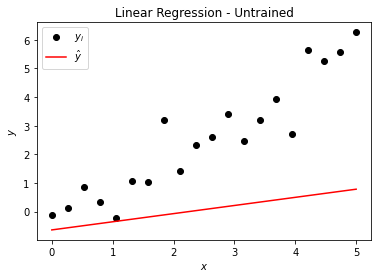

In [8]:
plt.scatter(X.cpu().numpy(), y.cpu().numpy(), label='$y_i$', color='black')
plt.plot(X.cpu().numpy(), yhat.detach().cpu().numpy(), label='$\hat y$', color='red')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.title('Linear Regression - Untrained')
plt.show()

To actually access the parameter values themselves, we can use the `parameters` method of the `model` object. This will always be true for accessing neural net parameters in pytorch. By default, `model.parameters()` gives a python **generator** object, which we need to first convert into a list to get `[W, b]`. An easier way for linear layers is to just use `model.weight` to get the weights `W`, and `model.bias` to get the bias `b`. Notice that each parameter has `requires_grad=True` on, which makes sense, given that those are the things we want to learn. This will always be true.

In [9]:
params = list(model.parameters())
W = model.weight
b = model.bias
params, W, b

([Parameter containing:
  tensor([[0.2847]], requires_grad=True),
  Parameter containing:
  tensor([-0.6429], requires_grad=True)],
 Parameter containing:
 tensor([[0.2847]], requires_grad=True),
 Parameter containing:
 tensor([-0.6429], requires_grad=True))

## Gradient Descent

To actually learn the parameters that give the best fit we'll use an algorithm called **gradient descent**, which is the basis for just about every learning algorithm in deep learning. Gradient descent is a method for solving minimization problems that involves using the derivative (i.e. the **gradient**) of a function to find its minimum as quickly as possible. More formally, given a loss function $L(\theta)$ to minimize with respect to some parameters $\theta$, gradient descent seeks to find the minimum $\hat \theta$ by iteratively computing the update
$$\theta_{n+1} = \theta_n - \alpha \frac{dL(\theta_n)}{d\theta}$$
until convergence, i.e. until the difference $\Delta \theta_n \equiv \theta_{n+1} - \theta_n$ is "small enough". When doing deep learning in practice, rather than specify some convergence criterion like this, it's more typical to just run gradient descent for so many iterations and stop it when the loss doesn't seem to be decreasing much anymore.

The value $\alpha$ in the update is called the **learning rate**, or **step size**. It controls how big the update is at each step of the iteration, and is generally manually specified by the programmer before training starts. Since the learning rate controls the speed of learning, the goal is to make it as high as possible so the algorithm will converge quicker. Unfortunately though there are limits to this. If you make the learning rate too large the loss will spiral off to infinity or just oscillate forever and fail to converge. So there's an art to tuning the learning rate, by making it as big as you can but without making it too big.

Let's apply gradient descent to our above linear regression problem to see if we can learn the best fit line to the given data. Before training our linear regression model we need to know what function it is we're trying to minimize. In deep learning this will always be the loss function averaged over all examples in the training set. For regression tasks, the loss function is usually the MSE loss defined above:
$$L(\hat y, y) \equiv L\big(\hat y(W, b), y\big) \equiv \frac{1}{N} \sum_{i=1}^N \big(\hat y_i - y_i \big)^2 \equiv \frac{1}{N} \sum_{i=1}^N \big(\hat y_i(W,b|x_i) - y_i \big)^2.$$

In pytorch, the loss is essentially just another layer that we can define and pass data through. To get the MSE loss we can just use the `nn.MSE` layer and then pass our predictions `yhat` through it to calculate the value. Note that in pytorch the order to pass arguments into the loss is always `yhat, y`, not the other way around.

In [10]:
loss_fn = nn.MSELoss()
loss = loss_fn(yhat, y)
loss

tensor(8.6615, grad_fn=<MseLossBackward0>)

Let's now try to minimize the MSE loss function with respect to $W$ and $b$ using gradient descent. Since the parameters are the weights $W$ and the bias $b$, the gradient updates will look like
$$W_{n+1} = W_n - \alpha \frac{dL(W_n, b_n)}{dW},$$
$$b_{n+1} = b_n - \alpha \frac{dL(W_n, b_n)}{db}.$$
Pytorch will automatically calculate these gradients for you using autodiff, so you don't have to worry about how to do it yourself. But if you're curious, for the MSE loss (and by coincidence also for all losses defined below) they turn out to be
$$\frac{dL(W, b)}{dW} = \frac{d}{dW} \frac{1}{N} \sum_{i=1}^N \big(\hat y_i - y_i\big)^2 = \frac{2}{N} \sum_{i=1}^N \big(\hat y_i - y_i\big) x_i^T,$$
$$\frac{dL(W, b)}{db} = \frac{d}{db} \frac{1}{N} \sum_{i=1}^N \big(\hat y_i - y_i\big)^2 = \frac{2}{N} \sum_{i=1}^N \big(\hat y_i - y_i\big).$$

Rather than code gradient descent from scratch, in pytorch it's better to define it as an **optimizer** object, and then "step" the optimizer until we're done training. The optimizer for gradient descent is called `torch.optim.SGD`, where SGD stands for **stochastic gradient descent**, which is a slight variation of gradient descent that works better for big datasets.

To use the optimizer object, we have to pass in the **parameters** we want to minimize, not the model itself. It's also here that we pass in the learning rate `lr` that'll be used for training the model. We'll just use `lr=0.1` here, though in practice you'd want to tune this. There are also other values we can pass in to improve the optimization, but we won't go into these right now.

In [11]:
opt = torch.optim.SGD(model.parameters(), lr=0.1)
opt

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

Now everything is in place to begin training the model. What you're about to see is the standard backbone of training loops in pytorch. Some version of this loop is used to train the vast majority of deep learning models in pytorch.
The high level procedure for training a neural network in pytorch is to, at each iteration:
- Grab some data `X, y`
- Zero the gradients (a technical detail we'll go into more in a future tutorial)
- Forward propagate the inputs `X` through the model to get the predictions `yhat`
- Calculate the loss as a function of the predictions `yhat` and the targets `y`
- Backpropagate the loss to compute the gradients of all the model parameters
- Use gradient descent (or another optimizer) to update the parameters

Even though this example is simple enough that we don't need to, it's common to visualize training by printing out the value of the loss every few iterations. It's also common to plot the loss curve either during training or at the end of training.

We can see that the loss is indeed decreasing towards zero, which is exactly what we want here, since the MSE loss must always be a positive value (it's a sum of squares).

In [12]:
num_iters = 100
for i in range(num_iters):
    opt.zero_grad()
    yhat = model(X)
    loss = loss_fn(yhat, y)
    loss.backward()
    opt.step()
    if i % 10 == 0:
        print(f'iter = {i} \t\t loss = {loss}')
print(f'iter = {i} \t\t loss = {loss}')

iter = 0 		 loss = 8.661486625671387
iter = 10 		 loss = 0.9074791669845581
iter = 20 		 loss = 0.5178236961364746
iter = 30 		 loss = 0.4980364441871643
iter = 40 		 loss = 0.4969569146633148
iter = 50 		 loss = 0.49687132239341736
iter = 60 		 loss = 0.49685564637184143
iter = 70 		 loss = 0.49685078859329224
iter = 80 		 loss = 0.49684906005859375
iter = 90 		 loss = 0.4968484044075012
iter = 99 		 loss = 0.4968481957912445


Let's go ahead and look at the parameters again and see if we found our best fit line to the data. It certainly looks like they've updated. The plot shows a much better fit to the data as well.

In [13]:
W = model.weight
b = model.bias
W, b

(Parameter containing:
 tensor([[1.2146]], requires_grad=True),
 Parameter containing:
 tensor([-0.4832], requires_grad=True))

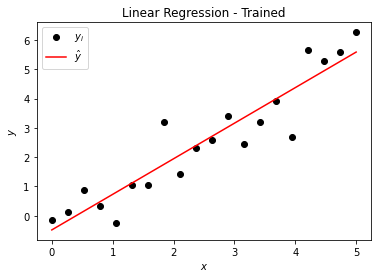

In [14]:
yhat = model(X)

plt.scatter(X.cpu().numpy(), y.cpu().numpy(), label='$y_i$', color='black')
plt.plot(X.cpu().numpy(), yhat.detach().cpu().numpy(), label='$\hat y$', color='red')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.title('Linear Regression - Trained')
plt.show()

## PyTorch Layers

Before moving onto logistic regression, it's worth showing how to actually implement a custom layer in pytorch, since we will have to for all but the simplest models later on. To do so we'll implement the above linear layer `nn.Linear` from scratch. In pytorch, a layer is any python class that
1. inherets from the nn.Module class,
2. implements a `forward` method that maps the layer input `x` to the layer output `y`.

Since we want parameters `W, b` that update with gradient descent, we need to keep track of their gradients, which means they need to have autodiff turned on. To play nice with the `nn` framework, the best way to do this for parameters is to wrap them inside `nn.Parameter`. This tells the layer that these are intended to be learnable parameters, and to keep track of them inside `model.parameters()`.

You always want to define your parameters inside the `__init__` method so that the layer object can keep track of them. The `forward` method is where the actual operation happens, which in this case is just the (vectorized) linear function
$$\hat y = WX + b.$$
Note that for linear layers the $WX$ is a *matrix multiply*, not an elementwise product. The bias vector $b$ is generally added to it directly using the standard numpy broadcasting rules. 

**Note:** There's always a question in deep learning of how to **initialize** the parameters at the beginning of training. There are a lot of ways to do this, and a lot of reasons for each, but for linear regression we'll be okay just initializing the weights using `torch.rand` and the bias using `torch.zeros`.

**Note:** We need to transpose the input and output vectors in `forward` due to the fact that we generally want to keep data in the format `(num_samples, num_features)` format. But the matrix multiply wants a `(num_features, num_samples)` format instead. An alternative that's often used is to not transpose the data, but to instead treat each feature as a row vector instead of as a column vector, and to transpose the weight matrix $W$ instead:
$$\hat y = X W^T + b.$$

Once you've implemented a custom layer like this, it's always a good idea to first check that it works by passing some data through the layer and making sure things look reasonable. In this case, it looks like we're okay, in that the shapes look right. In pytorch, if the shapes look okay, you're often 50% or more of the way to being right.

In [15]:
class Linear(nn.Module):
    def __init__(self, num_features, num_targets):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(num_targets, num_features))
        self.bias = nn.Parameter(torch.zeros(num_targets))
        
    def forward(self, X):
        X = X.T
        yhat = self.weight @ X + self.bias
        return yhat.T

In [16]:
linear = Linear(num_features, num_targets).to(device)
yhat = linear(X)
X.shape, y.shape, yhat.shape

(torch.Size([20, 1]), torch.Size([20, 1]), torch.Size([20, 1]))

## Logistic Regression

Recall that logistic regression is just linear regression with the **sigmoid** function
$$\sigma(z) \equiv \frac{1}{1 + \exp(z)}$$
applied to the linear layer's output (these are called the **logits**) to ensure that it outputs predictions are between 0 and 1.

Here's a reminder of what the sigmoid function looks like. The x-axis values are the logits and the y-axis values are the probabilities $p=\sigma(z)$ for each input $z$.

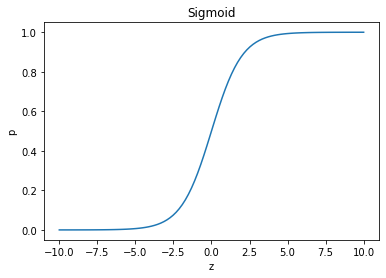

In [17]:
sigmoid = lambda z: 1 / (1 + np.exp(-z))

z = np.linspace(-10, 10, 100)
p = sigmoid(z)

plt.plot(z, p)
plt.xlabel('z')
plt.ylabel('p')
plt.title('Sigmoid')
plt.show()

For each pair $(x_i,y_i)$ in the dataset $i=1,\cdots,N$, the logistic regression model is formally defined by
$$\hat y \equiv \hat y(W,b|x) \equiv \sigma(Wx + b),$$
for some weights $W$ and bias $b$ to be learned.

The outputs $\hat y$ are interpreted as the probability that $y=1$ given the input data $X$, i.e.
$$\hat y = p(y=1|X).$$
To get the actual predictions $y_{pred}$, i.e. 0 and 1, one usually just rounds the probability $\hat y$ up or down:
$$y_{pred} \equiv \text{round}(\hat y).$$

The loss function to be minimized is the averaged **binary cross entropy** (BCE) loss defined by
$$L(\hat y, y) = -\frac{1}{N} \sum_{i=1}^N \big(y_i \log(\hat y_i) + (1-y_i) \log(1 - \hat y_i)\big).$$

In neural network terms, logistic regression is just a linear layer followed by a sigmoid function. In the terminology of neural networks, the sigmoid is called an **activation function**, and is loosely thought of as outputting the chance that the *output neuron fires* in *response* to its *inputs*.  Here's a diagram of how a logistic regression model might look as a neural network. It's exactly the same as linear regression diagram but with the sigmoid added. Note when it comes to neural nets, the activation isn't generally treated as a separately layer. Each linear + activation combo is considered a layer.

<img src="https://joshuagoings.com/assets/logistic.png" alt="linear" width="500">

Defining a logistic regression model in pytorch is pretty easy. We just need to chain a linear layer with a sigmoid layer. A sigmoid layer can be created with `nn.Sigmoid`. All it does is computes the sigmoid function. It doesn't have any parameters associated to it directly. To chain layers together sequentially we can use `nn.Sequential` and specify in order the layers we want in the network.

Let's again look at a simple example where `num_features = num_targets = 1`. We'll generate some random inputs `X` between 0 and 5, and create some simple ground truth labels `y` based on whether `X <= 2.5` or `X > 2.5`. Recall that to get the predicted labels `y_pred` from the output we need to threshold the probabilities `yhat`. In this simple case we'll say `y_pred = 1` if `yhat >= 0.5`, and `y_pred = 0` if `yhat < 0.5`

This is about as easy a classification problem as you can have, and a good model should be able to perfectly classify everything with 100% accuracy. As expected, the initialized model does a poor job since it hasn't been trained on the data yet. It's classifying *every* point as `y = 1`, which in this case means a poor 50% accuracy.

In [18]:
num_features = 1
num_targets = 1
num_samples = 20

X = torch.linspace(0, 5, num_samples).float().reshape(-1, 1).to(device)
y = torch.tensor([1 if X[i][0] > 2.5 else 0 for i in range(num_samples)]).float().reshape(-1, 1).to(device)
X.shape, y.shape

(torch.Size([20, 1]), torch.Size([20, 1]))

In [19]:
model = nn.Sequential(
    nn.Linear(num_features, num_targets),
    nn.Sigmoid()
)
model = model.to(device)
yhat = model(X).detach()
y_pred = yhat.round().detach()
yhat.shape, y_pred.shape

(torch.Size([20, 1]), torch.Size([20, 1]))

In [20]:
accuracy = (y == yhat.round().long()).sum() / len(y)
print(f'accuracy: {accuracy}')

accuracy: 0.5


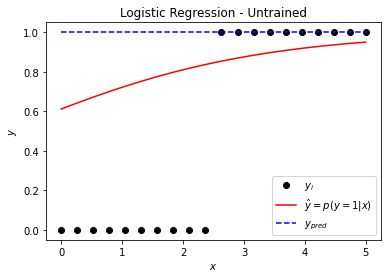

In [21]:
plt.scatter(X.cpu().numpy(), y.cpu().numpy(), label='$y_i$', color='black')
plt.plot(X.cpu().numpy(), yhat.cpu().numpy(), label='$\hat y = p(y=1|x)$', color='red')
plt.plot(X.cpu().numpy(), y_pred.cpu().numpy(), color='blue', linestyle='--', label='$y_{pred}$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='lower right')
plt.title('Logistic Regression - Untrained')
plt.show()

To improve the model we'll need to train it, meaning we need to specify the loss function as well. In pytorch, the binary cross entropy is given by the layer `nn.BCELoss`. Importantly, both the probabilities `yhat` *and* the labels `y` must be float tensors, or else you'll get an error with this loss function. Just one of those things.

In [22]:
loss_fn = nn.BCELoss()
loss = loss_fn(yhat, y)
loss

tensor(0.7280)

With the data, model, and loss function all defined it's just business as usual now. We define an optimizer, set a learning rate, and train the model. We'll train this one for 1000 iterations and again plot the results. As you should always expect is supposed to happen when things are working correctly, the loss is decreasing on average as the model trains.

It looks like we've got a model predicting with 100% accuracy now. The blue curve is `y_pred`, which perfectly matches the data points on this simple dataset.

In [23]:
opt = torch.optim.SGD(model.parameters(), lr=0.1)
num_iters = 1000
for i in range(num_iters):
    opt.zero_grad()
    yhat = model(X)
    loss = loss_fn(yhat, y)
    loss.backward()
    opt.step()
    if i % 100 == 0:
        print(f'iter = {i} \t\t loss = {loss}')
print(f'iter = {i} \t\t loss = {loss}')

iter = 0 		 loss = 0.7280346751213074
iter = 100 		 loss = 0.3962165117263794
iter = 200 		 loss = 0.2963736951351166
iter = 300 		 loss = 0.24626424908638
iter = 400 		 loss = 0.21588368713855743
iter = 500 		 loss = 0.19521813094615936
iter = 600 		 loss = 0.18007032573223114
iter = 700 		 loss = 0.1683775931596756
iter = 800 		 loss = 0.1590055376291275
iter = 900 		 loss = 0.15127626061439514
iter = 999 		 loss = 0.14481839537620544


In [24]:
yhat = model(X).detach()
y_pred = yhat.round().detach()

accuracy = (y == yhat.round().long()).sum() / len(y)
print(f'accuracy: {accuracy}')

accuracy: 1.0


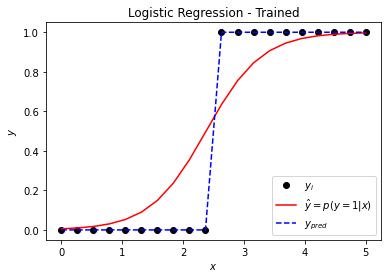

In [25]:
plt.scatter(X.cpu().numpy(), y.cpu().numpy(), label='$y_i$', color='black')
plt.plot(X.cpu().numpy(), yhat.cpu().numpy(), label='$\hat y = p(y=1|x)$', color='red')
plt.plot(X.cpu().numpy(), y_pred.cpu().numpy(), color='blue', linestyle='--', label='$y_{pred}$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='lower right')
plt.title('Logistic Regression - Trained')
plt.show()

## Multilayer Perceptrons

The simplest and oldest neural net architecture is what's called the **multilayer perceptron (MLP)**. Linear and logistic regression are just special types of MLPs in which there are no hidden layers, only input and output layers. An arbitrary MLP consists of many chained linear layers with activation functions. The extra layers inserted in between the input and output layers are called **hidden layers**. The number of hidden layers is called the **depth** of the neural network. A **shallow** neural network might have only one hidden layer, while a **deep** neural network will have many hidden layers.

A shallow MLP with one hidden layer is a model of the form
$$\hat y = f_2(W_2f_1(W_1x + b_1) + b_2),$$
where $f_1, f_2$ are some activation functions. They could be linear activations (i.e. no activation at all), sigmoids, or something else.

This may be easier to understand if we write it recursively. Define the output of the hidden layer as $a_1$. Then we can write
$$a_1 = f_1(W_1x + b_1),$$
$$\hat y = f_2(W_2 a_1 + b_2).$$
Looking at it this way, it looks kind of like we're just doing logistic regression twice in sequence. Taking the output from the first logistic regression, and making it the input to the second logistic regression. Of course, that's only true if both activation functions are sigmoids. If they're both linear we just get another version of linear regression. If they're different activations, e.g. the ReLU or softmax, which we'll define later, then we get something else.

Here's a diagram of what a shallow MLP might look like. In this case, there are 2 input features, 3 **hidden units**, and 1 target. We're taking the hidden activation $f_1$ to be a sigmoid, and the output activation $f_2$ to be linear. It's like taking your inputs, feeding them through logistic regression, and then feeding *those* outputs through another linear regression model. Note the decision to transpose the weights is just a different convention. It doesn't really matter.

<img src="https://joshuagoings.com/assets/shallow.png" alt="shallow" width="500">

Coding up a shallow MLP is just as simple as logistic regression was. We just need to specify what the activation functions will be. Here's an example that mimics the diagram, with a sigmoid hidden activation and a linear output activation. Notice that we now have a new config that we have to specify in advance, the number of hidden units we will have. As a general rule, the more hidden units you have, the more "expressive" that layer will be (and also the more likely to overfit it'll be).

In [26]:
num_features = 2
num_hidden = 3
num_targets = 1
num_samples = 100

model = nn.Sequential(
    nn.Linear(num_features, num_hidden),
    nn.Sigmoid(),
    nn.Linear(num_hidden, num_targets),
)
model

Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=3, out_features=1, bias=True)
)

In [27]:
X = torch.rand(num_samples, num_features).to(device)
y = torch.rand(num_samples, num_targets).to(device)
yhat = model(X)
X.shape, y.shape, yhat.shape

(torch.Size([100, 2]), torch.Size([100, 1]), torch.Size([100, 1]))

Deep MLPs are done the same way, except we can have *arbitrarily many* hidden layers, not just one or zero. Each hidden layer will have its own number of hidden units. Formally, an $L$-layer MLP is defined by the recursive sequence
$$a_0 = x$$
$$a_1 = f_1(W_1a_0 + b_1)$$
$$\vdots$$
$$a_{\ell} = f_{\ell}(W_{\ell}a_{\ell-1} + b_{\ell})$$
$$\vdots$$
$$a_L = f_L(W_La_{L-1} + b_L)$$
$$\hat y = a_L.$$

Here's a diagram of a (not so) deep MLP with 2 hidden layers, i.e. with $L=3$. There are 2 input features, 3 hidden units in layer 1, 3 hidden units in layer 2, and 1 target. A sigmoid activation is used for all but the output layer, which is a linear activation.

<img src="https://joshuagoings.com/assets/deep.png" alt="shallow" width="500">

Here's how one might express this model in code using pytorch. It's pretty much the same as the shallow MLP example, just with an extra hidden layer. Notice that the number of hidden units you choose for any hidden layer has *no effect* on the *data*. Given your data, you can choose the hidden unit sizes to be whatever you want to get the best performance. They're tunable, just like the learning rate. Such tunable configs in deep learning are called **hyperparameters**. They're not learned from training, but manually tuned to get the best model performance. There are many hyperparameters in deep learning, and we'll see more as we go.

In [28]:
num_features = 2
num_hidden_1 = 3
num_hidden_2 = 3
num_targets = 1
num_samples = 100

model = nn.Sequential(
    nn.Linear(num_features, num_hidden),
    nn.Sigmoid(),
    nn.Linear(num_hidden_1, num_hidden_2),
    nn.Sigmoid(),
    nn.Linear(num_hidden_2, num_targets),
)
model = model.to(device)
model

Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=3, out_features=3, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=3, out_features=1, bias=True)
)

In [29]:
X = torch.rand(num_samples, num_features).to(device)
y = torch.rand(num_samples, num_targets).to(device)
yhat = model(X)
X.shape, y.shape, yhat.shape

(torch.Size([100, 2]), torch.Size([100, 1]), torch.Size([100, 1]))

Training an MLP is done exactly the same way as training linear or logistic regression. The only real difference is that your loss function will depend on what your *output activation* is. As a general rule, for any sequential neural network, if your task is
- regression: use a linear output activation and a mean squared error loss,
- binary classification: use a sigmoid output activation and a binary cross entropy loss,
- multiclass classification: use a softmax output activation and a cross entropy loss (covered next).

## Multiclass Classification

Recall that multiclass classification has some slight differences with binary classification. Instead of the classes being $y=0,1$, for a $K$-class problem we'd have $y=0,1,\cdots,K-1$. Instead of one target value $\hat y = p(y=1|X)$, we instead have a **probability vector** of $K$ targets $\hat y_k = p(y=k|X)$ with the requirement that the probabilities sum to one, i.e.
$$\hat y_0 + \hat y_1 + \cdots + \hat y_{K-1} = 1.$$
To get the class predictions $y_{pred}$ we generally choose the **argmax** of the probability vector $\hat y$: 
$$y_{pred}=\text{argmax } \hat y = \text{argmax } (\hat y_0, \hat y_2, \cdots, \hat y_{K-1}).$$
That's just a fancy way of saying that if the max probability is $\hat y_k$ then we choose $y_{pred} = k$, which is just the index.

When doing multiclass classification with neural networks, the output activation is not the sigmoid function, but the **softmax** function defined by
$$\hat y_j = f(z_0,\cdots,z_{K-1})_j = \frac{e^{z_j}}{\sum_{k=0}^{K-1} e^{z_k}}.$$
The output of the softmax is *always* a vector of $K$ positive values that sum to one, i.e. valid probabilities. 

Here's a simple example of how the softmax works with $K=5$ values. Notice the softmax has a tendency to pick out the largest value in the input `z`, with the largest value getting the largest probability. The softmax always has this property, that the largest value will get a disproportionately high probability compared to the other values. This has to do with the exponentiation the function is doing, which tends to spread out the distances between values.

**Notice:** The max of `z` is also the max of `yhat`. That is, the softmax preserves the *order* of the input vector. This means that if the goal is just to get prediction labels (as is often true in classification tasks), we don't *need* to take the softmax at all. We'll see this fact become useful in a second.

In [30]:
z = torch.tensor([-1, 20, -8.7, 4, 0])
z

tensor([-1.0000, 20.0000, -8.7000,  4.0000,  0.0000])

In [31]:
yhat = z.softmax(dim=-1)  # or use: F.softmax(z)
print(f'sum of yhat: {yhat.sum().item()}')
yhat

sum of yhat: 1.0


tensor([7.5826e-10, 1.0000e+00, 3.4336e-13, 1.1254e-07, 2.0612e-09])

In [32]:
y_pred = yhat.argmax().item()
print(f'predicted label: {y_pred}')

predicted label: 1


The loss function for multiclass classification is similar to the binary cross entropy. If you're mathematically inclined, notice that (for a single data point) the binary cross entropy can be written as

$$
\begin{align}
L(\hat y, y)
  &= -y\log(\hat y) - (1-y)\log(1-\hat y) \\
  &= -[y=1]\log\big(p(y=1|x)\big) - [y=0]\log\big(p(y=0|x)\big) \\
  &= - \sum_{k=0}^1 [y=k]\log\big(p(y=k|x)\big) \\
  &= - \sum_{k=0}^1 [y=k]\log(\hat y_k).
\end{align}
$$

Evidently, the binary cross entropy is just a special case of the averaged **cross entropy** function defined over all data $i=1,\cdots,N$ by
$$L(\hat y, y) \equiv - \frac{1}{N}\sum_{i=1}^N \sum_{k=0}^{K-1} [y_i=k]\log((\hat y_i)_k).$$

It seems natural to choose the general cross entropy function for multiclass settings, and in fact that's what we do. Before talking about how to implement this function, however, there's an important numerical subtlety to address.

**Important:** Due to numerical stability issues, it's actually a bad idea to numerically take the softmax of a vector and then take the cross entropy of the softmax output. The reason for this is the [logsumexp](https://en.wikipedia.org/wiki/LogSumExp) problem, which is an issue where taking an exp followed by a sum followed by a log can cause values to either become infinity or zero. This means we've gotta be careful when dealing with logsumexp situations like the softmax + cross entropy calculation. One of the ways pytorch deals with this problem is this:
- Rather than take the softmax of the *logits* in the model we just have the model output the logits without a softmax layer at all
- We then pass these *logits* through the cross entropy loss, which is programmed to work with logits directly instead of softmax probabilities, but in a way that ensures numerical stability in calculations. In pytorch this version of the cross entropy loss is called `nn.CrossEntropyLoss`.
    - Remember we can do this since the softmax is order preserving, so it doesn't matter whether we work with the softmax probabilities or the logits when calculating predictions.
- For situations where we *need* the softmax probabilities directly, we can just call the `softmax()` method on the logits to get them any time we need them, which isn't often to be honest.
- Note there's actually *yet another* way pytorch deals with this problem, where instead of outputting logits from the model, one outputs the *log softmax*, and then uses another implementation of the cross entropy loss called `nn.NLLLoss` (stands for negative log likelihood loss, which is another name for the cross entropy). The results are completely equivalent, but in my opinion it's easier to work with the other version since it's simpler to remember.

## Multiclass Neural Network Example

Let's work through a slightly more interesting multiclass problem with $K=3$ classes of 500 examples, each with 2 features $x_1, x_2$ (so we can plot them). The sklearn `make_blogs` function is used to generate these classes as 3 distinct clusters sampled from a Gaussian mixture model. Notice that the samples overlap somewhat, meaning there is inherent, irreducible randomness to the data that we won't be able to "learn out" without overfitting. Another way to say this is that the dataset has a non-zero **Bayes Error**.

Note that 'y' is flat vector of integer labels `0, 1, 2`. It's usually easier to work with targets of this form when doing multiclass classification. You just have to make sure it's formatted as a long tensor or pytorch will scream at you when you try to calculate the cross entropy loss.

In [33]:
X, y = make_blobs(n_samples=500, n_features=2, centers=3, cluster_std=1.5, random_state=seed)
X.shape, y.shape

((500, 2), (500,))

In [34]:
X = torch.tensor(X).float().to(device)
y = torch.tensor(y).long().to(device)

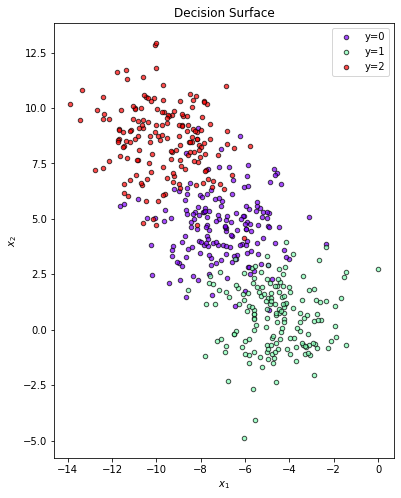

In [35]:
plot_model(None, X.cpu().numpy(), y.cpu().numpy())

Let's now try to classify this dataset using a 2-layer "deep" neural network with 20 hidden units in each layer. Such a model is just as easy to create as everything we've done so far.

As expected, the model doesn't do a good job at all of classifying the data since it hasn't been trained yet. In fact it's classifying everything as `y=1`, which gives only a 33% accuracy. That's what you'd expect from completely random data.

In [36]:
num_features = X.shape[1]
num_hidden_1 = 20
num_hidden_2 = 20
num_targets = len(y.unique())
num_samples = y.shape[0]

model = nn.Sequential(
    nn.Linear(num_features, num_hidden_1),
    nn.Sigmoid(),
    nn.Linear(num_hidden_1, num_hidden_2),
    nn.Sigmoid(),
    nn.Linear(num_hidden_2, num_targets),
)
model = model.to(device)
model

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=20, out_features=3, bias=True)
)

In [37]:
yhat = model(X)
yhat.shape

torch.Size([500, 3])

accuracy: 0.33399999141693115


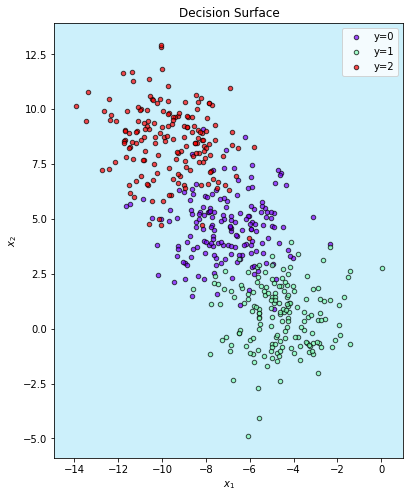

In [38]:
accuracy = (y == yhat.argmax(dim=-1).long()).sum() / len(y)
print(f'accuracy: {accuracy}')
plot_model(model, X.cpu().numpy(), y.cpu().numpy())

Now we can train the model in the usual way. We'll define the cross entropy loss, an SGD optimizer, and again train for 1000 iterations with a learning rate of 0.1. The loss is decreasing nicely.

Plotting the predictions, we can see the model is doing a much better job now, giving us almost an 89% accuracy! Can we do better? Probably a little. But remember the Bayes Error thing I mentioned. Because the data overlap there's an irreducible randomness in the data we're not gonna be able to get rid of. Trying to fit that randomness would be overfitting, so in my opinion this accuracy is good enough for this dataset, and we shouldn't try to fit anymore.

In [39]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.1)
num_iters = 1000
for i in range(num_iters):
    opt.zero_grad()
    yhat = model(X)
    loss = loss_fn(yhat, y)
    loss.backward()
    opt.step()
    if i % 100 == 0:
        print(f'iter = {i} \t\t loss = {loss}')
print(f'iter = {i} \t\t loss = {loss}')

iter = 0 		 loss = 1.1003139019012451
iter = 100 		 loss = 1.0425492525100708
iter = 200 		 loss = 0.8718676567077637
iter = 300 		 loss = 0.6912493109703064
iter = 400 		 loss = 0.6084460616111755
iter = 500 		 loss = 0.557965099811554
iter = 600 		 loss = 0.5144544243812561
iter = 700 		 loss = 0.471853643655777
iter = 800 		 loss = 0.4300784766674042
iter = 900 		 loss = 0.39148086309432983
iter = 999 		 loss = 0.3585359454154968


accuracy: 0.8899999856948853


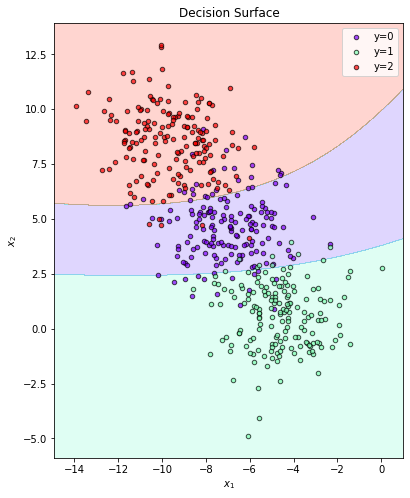

In [40]:
accuracy = (y == yhat.argmax(dim=-1).long()).sum() / len(y)
print(f'accuracy: {accuracy}')
plot_model(model, X.cpu().numpy(), y.cpu().numpy())